In [1]:
import gpflow
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.integrate import solve_ivp, odeint
from gpflow.utilities import print_summary, positive, to_default_float, set_trainable
from invariance_kernels import zero_mean, get_MOI, get_MOI2D, get_Pendulum_Invariance, get_SHM_Invariance, get_SHM2D_Invariance, get_Double_Pendulum_Invariance
from invariance_functions import degree_of_freedom, get_GPR_2Dmodel, get_SHM2D_data, evaluate_2Dmodel, get_double_pendulum_data, get_GPR_2Dmodel_sparse
from local_invariance_kernels import  get_Polynomial_2D_Local_Invariance
from parameterised_invariance_kernels import get_Polynomial_2D_Invariance, get_Polynomial_2D_Invariance_fixed
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '2'
mean = zero_mean(4)

time_step = 0.01
training_time = 0.1
testing_time = 0.1

max_x = 5
n_train = 3
train_starting_position1 = np.random.uniform(-max_x, max_x, (n_train))
train_starting_position2 = np.random.uniform(-max_x, max_x, (n_train))
train_starting_velocity1 = np.random.uniform(-max_x/5, max_x/5, (n_train))
train_starting_velocity2 = np.random.uniform(-max_x/5, max_x/5, (n_train))
test_starting_position1 = np.random.uniform(-max_x, max_x)
test_starting_position2 = np.random.uniform(-max_x, max_x)
test_starting_velocity1 = np.random.uniform(-max_x/5, max_x/5)
test_starting_velocity2 = np.random.uniform(-max_x/5, max_x/5)

print(train_starting_position1)
print(train_starting_position2)
print(train_starting_velocity1)
print(train_starting_velocity2)

print(test_starting_position1)
print(test_starting_position2)
print(test_starting_velocity1)
print(test_starting_velocity2)

data = get_SHM2D_data(time_step, training_time, 1e-8, train_starting_position1, train_starting_position2, train_starting_velocity1, train_starting_velocity2) #switch
test_data = get_SHM2D_data(time_step, testing_time, 1e-8,[test_starting_position1],[test_starting_position2],[test_starting_velocity1],[test_starting_velocity2] )
for jitter in [1e-8]:
#    moi = get_GPR_2Dmodel(get_MOI2D(), mean, data, "adam", 1000, 0.1)[0]
#    print("%s, "%round(moi.log_marginal_likelihood().numpy()))
#    evaluate_moi = evaluate_2Dmodel(moi, test_data, time_step)
#    print(evaluate_moi[:2])
    moi = get_GPR_2Dmodel(get_MOI2D(), mean, data, "scipy", 1000, 0.1)
    print("%s, "%round(moi.log_marginal_likelihood().numpy()))
    evaluate_moi = evaluate_2Dmodel(moi, test_data, time_step)
    print(evaluate_moi[:2])
    for invar_density in [7]: #np.arange(10, 30, 10):
            try:
                polynomial_degree = 1
#                kernel = get_Polynomial_2D_Local_Invariance(4, 200, jitter, [polynomial_degree,polynomial_degree,polynomial_degree,polynomial_degree]) #switch
                print("polynomial")
                kernel = get_Polynomial_2D_Invariance(5, invar_density, jitter, [polynomial_degree,polynomial_degree,polynomial_degree,polynomial_degree]) #switch
                m, best = get_GPR_2Dmodel_sparse(kernel, mean, data, "adam", 2000, 0.1, 0.1)
                print(round(m.log_marginal_likelihood().numpy()))
                evaluate_invariance = evaluate_2Dmodel(m, test_data, time_step)
                print(evaluate_invariance[:2])
                print(kernel.f1_poly)
                print(kernel.f2_poly)
                print(kernel.g1_poly)
                print(kernel.g2_poly)
#                kernel = get_Polynomial_2D_Local_Invariance(4, 200, jitter, [polynomial_degree,polynomial_degree,polynomial_degree,polynomial_degree]) #switch
                print("polynomial_fixed")
                kernel = get_Polynomial_2D_Invariance_fixed(3, invar_density, jitter, [polynomial_degree,polynomial_degree,polynomial_degree,polynomial_degree]) #switch
                m, best_ = get_GPR_2Dmodel(kernel, mean, data, "adam", 1, 0.01)
                print(round(m.log_marginal_likelihood().numpy()))
                evaluate_invariance = evaluate_2Dmodel(m, test_data, time_step)
                print(evaluate_invariance[:2])
                '''
                print("SHM")
                kernel = get_SHM2D_Invariance(3, invar_density, jitter) #switch
                m = get_GPR_2Dmodel(kernel, mean, data, "adam", 1000, 0.1)[0]
                print(round(m.log_marginal_likelihood().numpy()))
                evaluate_invariance = evaluate_2Dmodel(m, test_data, time_step)
                print(evaluate_invariance[:2])
                '''

            except tf.errors.InvalidArgumentError:
                print("jitter too small")
                break 


[-0.74714854 -3.00239634  2.65645661]
[-1.55342805 -1.18228446  1.9162983 ]
[0.55986398 0.29897742 0.45646205]
[-0.56762516  0.59500263  0.38485888]
-3.7773334456096332
2.8739920050277687
0.10430327939209194
-0.78779645643524
412, 
(1.8845062407745448, 0.003332842336725323)
polynomial


In [13]:
tf.reduce_sum(tf.abs(m.kernel.f1_poly))
#best

<tf.Tensor: shape=(), dtype=float64, numpy=0.10000000000000009>

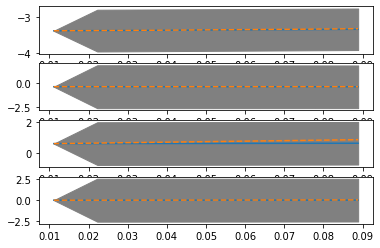

In [3]:

import matplotlib.pyplot as plt
t = np.linspace(0, testing_time, int(testing_time/time_step))[1:-1]
fig, axs = plt.subplots(4)
axs[0].plot(t,evaluate_moi[2][:,0])
axs[0].fill_between(t,evaluate_moi[2][:,0]+1.96*np.sqrt(evaluate_moi[3][:,0]+moi.likelihood.variance.numpy()),evaluate_moi[2][:,0]-1.96*np.sqrt(evaluate_moi[3][:,0]+moi.likelihood.variance.numpy()), color="grey")
axs[0].plot(t, test_data[0][:,0],'--')
axs[1].plot(t,evaluate_moi[2][:,1])
axs[1].fill_between(t,evaluate_moi[2][:,1]+1.96*np.sqrt(evaluate_moi[3][:,1]+moi.likelihood.variance.numpy()),evaluate_moi[2][:,1]-1.96*np.sqrt(evaluate_moi[3][:,1]+moi.likelihood.variance.numpy()), color="grey")
axs[1].plot(t, test_data[0][:,1],'--')
axs[2].plot(t,evaluate_moi[2][:,2])
axs[2].fill_between(t,evaluate_moi[2][:,2]+1.96*np.sqrt(evaluate_moi[3][:,2]+moi.likelihood.variance.numpy()),evaluate_moi[2][:,2]-1.96*np.sqrt(evaluate_moi[3][:,2]+moi.likelihood.variance.numpy()), color="grey")
axs[2].plot(t, test_data[0][:,2],'--')
axs[3].plot(t,evaluate_moi[2][:,3])
axs[3].fill_between(t,evaluate_moi[2][:,3]+1.96*np.sqrt(evaluate_moi[3][:,3]+moi.likelihood.variance.numpy()),evaluate_moi[2][:,3]-1.96*np.sqrt(evaluate_moi[3][:,3]+moi.likelihood.variance.numpy()), color="grey")
axs[3].plot(t, test_data[0][:,3],'--')

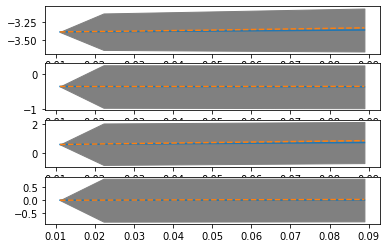

In [4]:

fig, axs = plt.subplots(4)
axs[0].plot(t,evaluate_invariance[2][:,0])
axs[0].fill_between(t,evaluate_invariance[2][:,0]+1.96*np.sqrt(evaluate_invariance[3][:,0]+m.likelihood.variance.numpy()),evaluate_invariance[2][:,0]-1.96*np.sqrt(evaluate_invariance[3][:,0]+m.likelihood.variance.numpy()), color="grey")
axs[0].plot(t, test_data[0][:,0],'--')
axs[1].plot(t,evaluate_invariance[2][:,1])
axs[1].fill_between(t,evaluate_invariance[2][:,1]+1.96*np.sqrt(evaluate_invariance[3][:,1]+m.likelihood.variance.numpy()),evaluate_invariance[2][:,1]-1.96*np.sqrt(evaluate_invariance[3][:,1]+m.likelihood.variance.numpy()), color="grey")
axs[1].plot(t, test_data[0][:,1],'--')
axs[2].plot(t,evaluate_invariance[2][:,2])
axs[2].fill_between(t,evaluate_invariance[2][:,2]+1.96*np.sqrt(evaluate_invariance[3][:,2]+m.likelihood.variance.numpy()),evaluate_invariance[2][:,2]-1.96*np.sqrt(evaluate_invariance[3][:,2]+m.likelihood.variance.numpy()), color="grey")
axs[2].plot(t, test_data[0][:,2],'--')
axs[3].plot(t,evaluate_invariance[2][:,3])
axs[3].fill_between(t,evaluate_invariance[2][:,3]+1.96*np.sqrt(evaluate_invariance[3][:,3]+m.likelihood.variance.numpy()),evaluate_invariance[2][:,3]-1.96*np.sqrt(evaluate_invariance[3][:,3]+m.likelihood.variance.numpy()), color="grey")
axs[3].plot(t, test_data[0][:,3],'--')